## Data preparation:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, learning_curve, ShuffleSplit 
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer, r2_score
from scipy.stats import randint, uniform, norm
import data_preparation as prep
from sklearn.dummy import DummyRegressor
import xgboost as xgb
import lightgbm as lgb

N_JOBS = -1

## Load data

In [2]:
X_train, y_train, X_test = prep.main()

In [3]:
print(X_train.head(2))

    BldgType_1Fam  BldgType_2fmCon  BldgType_Duplex  BldgType_Twnhs  \
Id                                                                    
1           0.452           -0.147           -0.197          -0.185   
2           0.452           -0.147           -0.197          -0.185   

    BldgType_TwnhsE  CentralAir_N  CentralAir_Y  Condition1_Artery  \
Id                                                                   
1            -0.291        -0.268         0.268             -0.181   
2            -0.291        -0.268         0.268             -0.181   

    Condition1_Feedr  Condition1_Norm   ...    PoolQC  ScreenPorch  Street  \
Id                                      ...                                  
1             -0.243            0.402   ...    -0.050       -0.308   0.064   
2              4.109           -2.486   ...    -0.050       -0.308   0.064   

    TotRmsAbvGrd  TotalBsmtSF  Utilities  WoodDeckSF  YearBuilt  YearRemodAdd  \
Id                                      

In [4]:
print(y_train.head(2))

Id
1   12.248
2   12.109
Name: SalePrice, dtype: float64


In [5]:
print(y_train.describe())

count   1456.000
mean      12.022
std        0.396
min       10.460
25%       11.775
50%       12.002
75%       12.274
max       13.346
Name: SalePrice, dtype: float64


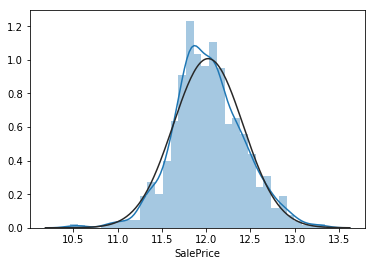

In [6]:
sns.distplot(y_train, fit=norm)
plt.show()

https://datascience.stackexchange.com/questions/20237/why-do-we-convert-skewed-data-into-a-normal-distribution

In [7]:
print(X_test.head(2))

      BldgType_1Fam  BldgType_2fmCon  BldgType_Duplex  BldgType_Twnhs  \
Id                                                                      
1461          0.452           -0.147           -0.197          -0.185   
1462          0.452           -0.147           -0.197          -0.185   

      BldgType_TwnhsE  CentralAir_N  CentralAir_Y  Condition1_Artery  \
Id                                                                     
1461           -0.291        -0.268         0.268             -0.181   
1462           -0.291        -0.268         0.268             -0.181   

      Condition1_Feedr  Condition1_Norm   ...    PoolQC  ScreenPorch  Street  \
Id                                        ...                                  
1461             4.109           -2.486   ...    -0.050        2.861   0.064   
1462            -0.243            0.402   ...    -0.050       -0.308   0.064   

      TotRmsAbvGrd  TotalBsmtSF  Utilities  WoodDeckSF  YearBuilt  \
Id                          

## Submission function

In [8]:
def submission(model, X_test, file):
    Id = pd.DataFrame(X_test.index, columns=['Id'])
    y_pred = np.exp(model.predict(X_test))
    print(y_pred)
    prediction = pd.DataFrame(y_pred, columns=['SalePrice'])
    res = pd.concat([Id, prediction], axis=1)
    res.to_csv(path_or_buf="submission_"+file,index=False)

## Score function

In [9]:
def score(model, X, y):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    scores= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    print("scores=", scores)
    print("Score: mean="+str(scores.mean())+" std="+str(scores.std()))

## Grid search

In [10]:
def optimize_hyperparameters(model, param_grid, X, y):
    grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=N_JOBS, cv=3, verbose=1)
    grid_search.fit(X, y)
    print("Best params:")
    print(grid_search.best_params_)

## Randomized search

In [11]:
def optimize_hyperparameters_random(model, param_dist, n_iterations, X, y, n_jobs):
    randomized_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iterations, scoring="neg_mean_squared_error", n_jobs=n_jobs, cv=3, verbose=1)
    randomized_search.fit(X, y)
    print("Best params:")
    print(randomized_search.best_params_)

## Linear model

### Ridge

In [12]:
class PositiveRidge(Ridge): 
    def __init__(self, alpha=1.0, fit_intercept=True, normalize=False, random_state=42, negative_values=0):
        Ridge.__init__(self, alpha, fit_intercept, normalize, random_state)
        if negative_values < 0:
            self.negative_values = 0
        else:
            self.negative_values = negative_values

    def predict(self, X, y=None): 
        y_pred = Ridge.predict(self, X)
        #if(y_pred[y_pred < 0].sum() < 0):
        #    print("====Replace negative values====")
        y_pred[y_pred < 0] = self.negative_values
        return y_pred

In [13]:
param_dist = {
    "alpha": uniform(loc=0, scale=300),
    "fit_intercept": [True],
    "normalize": [False],
    "random_state": [42],
    "negative_values": uniform(loc=1, scale=300000),
}
model = PositiveRidge()
#optimize_hyperparameters_random(model, param_dist, 1000, X_train, y_train.values.ravel(), n_jobs=8)

In [14]:
ridge = PositiveRidge(alpha=176.22651217200971, fit_intercept=True, negative_values=0, normalize=False, random_state=42)
score(ridge, X_train, y_train.values.ravel()) #0.116

scores= [ 0.10972043  0.11916625  0.1260496   0.11265393  0.11450826]
Score: mean=0.116419696539 std=0.00570952644634


In [15]:
ridge.fit(X_train, y_train)
submission(ridge, X_test, "ridge")

[ 123566.54965774  163647.57026157  182052.32147979 ...,  165255.00775944
  119018.10983571  217861.5148297 ]


### Lasso

In [16]:
class PositiveLasso(Lasso): 
    def __init__(self, alpha=1.0, fit_intercept=True, normalize=False, max_iter=10000, random_state=42, negative_values=0):
        Lasso.__init__(self, alpha=alpha, fit_intercept=fit_intercept, normalize=normalize, max_iter=max_iter, random_state=random_state)
        if negative_values < 0:
            self.negative_values = 0
        else:
            self.negative_values = negative_values

    def predict(self, X, y=None): 
        y_pred = Lasso.predict(self, X)
        #if(y_pred[y_pred < 0].sum() < 0):
        #    print("====Replace negative values====")
        y_pred[y_pred < 0] = self.negative_values
        return y_pred

In [17]:
param_dist = {
    "alpha": uniform(loc=0, scale=50000),
    "fit_intercept": [True],
    "normalize": [False],
    "max_iter": [100000],
    "random_state": [42],
    "negative_values": uniform(loc=1, scale=300000),
}
model = PositiveLasso()
#optimize_hyperparameters_random(model, param_dist, 1000, X_train, y_train.values.ravel(), n_jobs=8)

In [18]:
lasso = PositiveLasso(alpha=28537.611854185361, fit_intercept=True, max_iter=10000, negative_values=0, normalize=False, random_state=42)
score(lasso, X_train, y_train.values.ravel()) #0.40

scores= [ 0.38687812  0.42585545  0.40101404  0.38336099  0.38196752]
Score: mean=0.395815225071 std=0.0164692512447


### Elastic net

In [19]:
class PositiveElasticNet(ElasticNet): 
    def __init__(self, alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False, max_iter=10000, random_state=42, negative_values=0):
        ElasticNet.__init__(self, alpha=alpha, l1_ratio=l1_ratio, fit_intercept=fit_intercept, normalize=normalize, max_iter=max_iter, random_state=random_state)
        if negative_values < 0:
            self.negative_values = 0
        else:
            self.negative_values = negative_values

    def predict(self, X, y=None): 
        y_pred = ElasticNet.predict(self, X)
        #if(y_pred[y_pred < 0].sum() < 0):
        #    print("====Replace negative values====")
        y_pred[y_pred < 0] = self.negative_values
        return y_pred

In [20]:
param_dist = {
    "alpha": uniform(loc=0, scale=1),
    "l1_ratio": uniform(loc=0, scale=1),
    "fit_intercept": [True],
    "normalize": [False],
    "max_iter": [100000],
    "random_state": [42],
    "negative_values": uniform(loc=1, scale=300000),
}
model = PositiveElasticNet()
#optimize_hyperparameters_random(model, param_dist, 1000, X_train, y_train.values.ravel(), n_jobs=8)

In [21]:
elastic_net = PositiveElasticNet(alpha=0.0048016016919922855, fit_intercept=True, l1_ratio=0.88336787754196211, max_iter=100000, negative_values=0, normalize=False, random_state=42)
score(elastic_net, X_train, y_train.values.ravel()) #0.11033386485

scores= [ 0.10160697  0.11061807  0.11956958  0.10952906  0.11034564]
Score: mean=0.11033386485 std=0.00569536009044


In [22]:
elastic_net.fit(X_train, y_train)
submission(elastic_net, X_test, "elastic_net")

[ 121568.54107706  158996.29781961  180366.28486427 ...,  164451.1419055
  122051.85513069  228486.87614812]


## Random forest

In [23]:
param_dist = {
    "max_depth": randint(1,40),
    "max_features": randint(1,200),
    "min_samples_split": randint(2,100),
    "min_samples_leaf": randint(2,100),
    "bootstrap": [True, False],
    "n_jobs": [N_JOBS],
    "verbose": [0], 
    "n_estimators": [100],
    "random_state": [42],
}
model = RandomForestRegressor()
#optimize_hyperparameters_random(model, param_dist, 1000, X_train, y_train.values.ravel())

In [24]:
random_forest = RandomForestRegressor(bootstrap="False", max_depth=30, max_features=81, min_samples_leaf=3, min_samples_split=5, n_estimators=100, n_jobs=-1, random_state=42)
score(random_forest, X_train, y_train.values.ravel()) #0.134

scores= [ 0.12893338  0.14032829  0.14194883  0.12999325  0.12878683]
Score: mean=0.133998115168 std=0.0058674200217


In [25]:
random_forest.fit(X_train, y_train)
submission(random_forest, X_test, "random_forest")

[ 123424.44175231  152033.08123303  180562.08021006 ...,  152385.16527412
  114881.28340007  217826.56650972]


In [26]:
param_dist = {
    "n_estimators": [100], 
    "max_depth": randint(1,100), 
    "max_features": randint(1,200), 
    "bootstrap": [True, False], 
    "oob_score": [False], 
    "n_jobs": [N_JOBS], 
    "random_state": [42], 
    "verbose": [0], 
}
model = ExtraTreesRegressor()
#optimize_hyperparameters_random(model, param_dist, 100, X_train, y_train.values.ravel(), N_JOBS)

In [27]:
extra_trees = ExtraTreesRegressor(bootstrap="False", max_depth=47, max_features=163, n_estimators=1000, n_jobs=-1, random_state=42)
score(extra_trees, X_train, y_train.values.ravel()) #0.133

scores= [ 0.12059775  0.14287246  0.14600972  0.12766953  0.12890339]
Score: mean=0.133210570141 std=0.00964892292068


In [28]:
extra_trees.fit(X_train, y_train)
submission(extra_trees, X_test, "extra_trees")

[ 121423.78661994  150852.98294307  175991.71664052 ...,  148480.91585168
  110396.20069791  215083.46994073]


## Adaboost

In [29]:
param_dist = {
    "base_estimator": [elastic_net], 
    "n_estimators": [50],
    "learning_rate": uniform(0,1), 
    "loss": ["linear"], 
    'random_state': [42]
}
model = AdaBoostRegressor()
#optimize_hyperparameters_random(model, param_dist, 100, X_train, y_train.values.ravel(), N_JOBS)

In [30]:
ada_boost = AdaBoostRegressor(base_estimator=elastic_net, learning_rate=0.0035798453369878525, loss="linear", n_estimators=50, random_state=42)
score(ada_boost, X_train, y_train.values.ravel()) #0.110

scores= [ 0.10117776  0.11009225  0.11988806  0.10819525  0.11065833]
Score: mean=0.110002333212 std=0.00598839899799


In [31]:
ada_boost.fit(X_train, y_train)
submission(ada_boost, X_test, "ada_boost")

[ 122048.22365385  160241.80062217  180209.57390375 ...,  164875.4202714
  120693.28337825  227822.09503442]


In [32]:
param_dist = {
    "base_estimator": [GBRT], 
    "n_estimators": [10],
    "learning_rate": uniform(0,1), 
    "loss": ["exponential"], 
    'random_state': [42]
}
model = AdaBoostRegressor()
#optimize_hyperparameters_random(model, param_dist, 50, X_train, y_train.values.ravel(), -1)

NameError: name 'GBRT' is not defined

In [41]:
ada_boost_GBRT = AdaBoostRegressor(base_estimator=GBRT, learning_rate=0.01074588992181591, loss="exponential", n_estimators=10, random_state=42)
score(ada_boost_GBRT, X_train, y_train.values.ravel()) #0.115

scores= [ 0.11314424  0.11679607  0.12114465  0.11249559  0.11264412]
Score: mean=0.11524493514 std=0.00334510679766


In [42]:
ada_boost_GBRT.fit(X_train, y_train)
submission(ada_boost_GBRT, X_test, "ada_boost_GBRT")

[ 124119.86580644  155503.57598605  186661.2722255  ...,  168881.67789574
  118058.93750132  208549.25618491]


## Gradient Boosting Trees

In [34]:
param_dist = {
    #"loss": ['huber'],
    #"alpha": uniform(0,1),
    "learning_rate": uniform(0.01, 0.5),
    "max_depth": randint(1,40),
    "max_features": randint(1,200),
    "min_samples_split": randint(2,100),
    "min_samples_leaf": randint(2,100),
    "verbose": [0], 
    "n_estimators": [10000],
    "random_state": [42],
}
model = GradientBoostingRegressor()
#optimize_hyperparameters_random(model, param_dist, 100, X_train, y_train.values.ravel(), N_JOBS)

In [35]:
GBRT = GradientBoostingRegressor(alpha=0.728, learning_rate=0.085, loss="huber", max_depth=20, max_features=21, min_samples_leaf=19, min_samples_split=78, n_estimators=100, random_state=42)
#score(GBRT, X_train, y_train.values.ravel()) #0.121

In [36]:
GBRT = GradientBoostingRegressor(learning_rate=0.0816, max_depth=12, max_features=19, min_samples_leaf=2, min_samples_split=61, n_estimators=100, random_state=42)
#score(GBRT, X_train, y_train.values.ravel()) #0.119

In [37]:
GBRT = GradientBoostingRegressor(learning_rate=0.012339723882381295, max_depth=39, max_features=4, min_samples_leaf=4, min_samples_split=48, n_estimators=10000, random_state=42)
#score(GBRT, X_train, y_train.values.ravel()) #0.119

In [38]:
GBRT = GradientBoostingRegressor(learning_rate=0.20951691351320212, max_depth=1, max_features=118, min_samples_leaf=15, min_samples_split=26, n_estimators=1000, random_state=42)
score(GBRT, X_train, y_train.values.ravel()) #0.117

scores= [ 0.11464471  0.12231083  0.12255839  0.11372461  0.11418759]
Score: mean=0.117485229046 std=0.00405237156595


In [39]:
GBRT.fit(X_train, y_train)
submission(GBRT, X_test, "GBRT")

[ 118972.22161729  156856.6118166   186315.4638387  ...,  174913.5996919
  114875.74043249  216110.41645273]


## XGBoost

In [43]:
param_dist = {
    "max_depth": randint(1,100),
    "min_child_weight": randint(0,1000),
    "gamma": randint(0,100),
    "n_estimators": [10],
    "silent": [False],
    "n_jobs": [N_JOBS],
    "random_state": [42],
}
XGBoost = xgb.XGBRegressor()
#optimize_hyperparameters_random(XGBoost, param_dist, 100, X_train, y_train.values.ravel())

In [44]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score(XGBoost, X_train, y_train.values.ravel()) #0.117

scores= [ 0.1137977   0.12899517  0.12457906  0.1192399   0.11837587]
Score: mean=0.120997539615 std=0.00526478049823


In [45]:
XGBoost.fit(X_train, y_train)
submission(XGBoost, X_test, "XGBoost")

[ 122667.8515625  162690.703125   180439.421875  ...,  158258.921875
  119059.984375   208086.953125 ]


In [46]:
param_grid = {
    "max_depth": [1, 25, 50],
    "learning_rate": [0.25, 0.50],
    "min_child_weight": [1, 20, 50],
    "gamma": [1, 50, 75],
    "n_estimators": [10],
    "silent": [False],
    "n_jobs": [N_JOBS],
    "random_state": [42], 
    }
model = xgb.XGBRegressor()
#optimize_hyperparameters(model,param_grid, X_train, y_train.values.ravel())

In [47]:
#XGBoost = xgb.XGBRegressor(gamma=1, learning_rate=0.5, max_depth=25, min_child_weight=1, n_estimators=10, n_jobs=-1, random_state=42)
#score(XGBoost, X_train, y_train.values.ravel()) #0.145

## LightGBM

In [ ]:
param_dist = {
    "num_leaves": randint(2,100),
    "max_depth": randint(1,100),
    "min_data_in_leaf": randint(1,50),
    "learning_rate": [0.01],
    "n_estimators": [1000],
    #"subsample": uniform(0.4, 0.9),
    #"colsample_bytree": uniform(0.4, 1),
    "reg_alpha": uniform(0, 1),
    #"reg_lambda ": uniform(0, 1),
    "silent": [0],
    "n_jobs": [8],
    "random_state": [42],
}
model = lgb.LGBMRegressor()
optimize_hyperparameters_random(model, param_dist, 5, X_train, y_train.values.ravel(), 1)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [71]:
LGBM = lgb.LGBMRegressor(learning_rate=0.01, max_depth=28, n_estimators=2000, n_jobs=8, num_leaves=5, random_state=42, reg_alpha=0.096030659906092053, reg_lambda=0.82943289588961044)

X, X_val, y, y_val = train_test_split(X_train, y_train, random_state=49)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(500, 5000):
    print(n_estimators)
    LGBM.n_estimators = n_estimators
    LGBM.fit(X, y)
    y_pred = LGBM.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping


print(LGBM.n_estimators)

500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749


2239
2240
2241
2242


KeyboardInterrupt: 

In [ ]:
X, X_val, y, y_val = train_test_split(X_train, y_train, random_state=49)
LGBM = lgb.LGBMRegressor(learning_rate=0.01, max_depth=28, n_estimators=2000, n_jobs=8, num_leaves=5, random_state=42, reg_alpha=0.096030659906092053, reg_lambda=0.82943289588961044)
LGBM.fit(X, y, )

In [55]:
LGBM = lgb.LGBMRegressor(learning_rate=0.01, max_depth=28, n_estimators=2000, n_jobs=-1, num_leaves=5, random_state=42, reg_alpha=0.096030659906092053, reg_lambda=0.82943289588961044)
score(LGBM, X_train, y_train.values.ravel()) #0.116812224333

scores= [ 0.11017289  0.1234964   0.12122808  0.1128838   0.11627994]
Score: mean=0.116812224333 std=0.00497944980108


## SVM

### kernel: [linear, poly, rbf, sigmoid, precomputed]

In [60]:
param_dist = {
    "C": uniform(0, 100),
    "epsilon": uniform(0, 1),
    "max_iter": [1000],
    "dual": [False],
    "loss": ["squared_epsilon_insensitive"]
    }
model = LinearSVR()
#optimize_hyperparameters_random(model, param_dist, 300, X_train, y_train.values.ravel(), n_jobs=-1)

In [61]:
svm_linear = LinearSVR(
    C=60.61,
    dual=False,
    epsilon=0.07,
    loss="squared_epsilon_insensitive",
    max_iter=1000
)
score(svm_linear, X_train, y_train.values.ravel()) #0.134

scores= [ 1.6185471   1.20339657  1.4287821   1.57175402  2.73730187]
Score: mean=1.71195633255 std=0.532641742683


In [62]:
#svm_linear.fit(X_train, y_train)
#submission(svm_linear, X_test, "svm")

In [63]:
param_dist = {
    "kernel": ['linear'],
    "C": uniform(0.1,200),
    "epsilon": uniform(loc=0.1, scale=1),
    "cache_size": [5000],
}
model = SVR()
#optimize_hyperparameters_random(model, param_dist, 100, X_train, y_train.values.ravel(), n_jobs=-1)

In [64]:
svm = SVR(C=83.144409878382945, cache_size=5000, epsilon=0.39823088915121874, kernel='linear')
score(svm, X_train, y_train.values.ravel()) #0.135

scores= [ 0.1593338   0.17040264  0.16816442  0.15191722  0.16459575]
Score: mean=0.162882766614 std=0.00663651965007


In [65]:
param_dist = {
    "kernel": ['poly'],
    "degree": randint(1,5),
    "C": randint(0,20000),
    "epsilon": uniform(loc=0, scale=1),
    "shrinking": [False, True], 
    "cache_size": [5000],
}
model = SVR()
#optimize_hyperparameters_random(model, param_dist, 100, X_train, y_train.values.ravel())

In [66]:
svm = SVR(C=6322, degree=2, cache_size=5000, epsilon=0.29799211072674692, kernel='poly', shrinking=False)
score(svm, X_train, y_train.values.ravel()) #0.248

scores= [ 0.25031295  0.26946261  0.25582644  0.2383986   0.24072879]
Score: mean=0.250945878257 std=0.011215280833


In [67]:
param_dist = {
    "kernel": ['rbf'],
    "C": randint(0,7000),
    "gamma": uniform(loc=0, scale=1),
    "epsilon": uniform(loc=0, scale=300),
    "shrinking": [False, True], 
    "cache_size": [5000],
}
#optimize_random_hyperparameters_SVR(param_dist, 100, X_train, y_train.values.ravel())

In [68]:
svm = SVR(C=1397, degree=1, cache_size=5000, epsilon=139.00647643017697, gamma=0.023103258942649085, kernel='rbf', shrinking=False)
score(svm, X_train, y_train.values.ravel()) #0.135

scores= [ 0.40839392  0.44187549  0.42115386  0.39047331  0.40530929]
Score: mean=0.413441173072 std=0.017245989769


## Learning curves

In [69]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1,ylim=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring=make_scorer(mean_squared_error, greater_is_better=False), cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=1)
    train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    #train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))
    #test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    #plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    #plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

[learning_curve] Training set sizes: [ 116  378  640  902 1164]
[learning_curve] Training set sizes: [ 116  378  640  902 1164]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished


[learning_curve] Training set sizes: [ 116  378  640  902 1164]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.6s finished


[learning_curve] Training set sizes: [ 116  378  640  902 1164]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.5s finished


[learning_curve] Training set sizes: [ 116  378  640  902 1164]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   47.4s finished


[learning_curve] Training set sizes: [ 116  378  640  902 1164]


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.5min finished


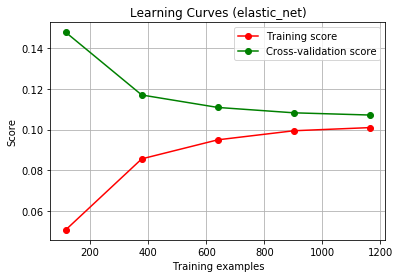

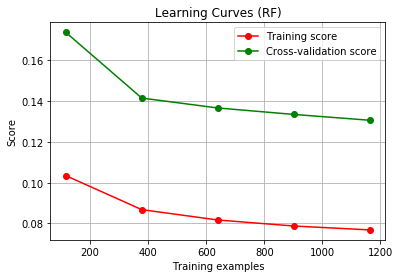

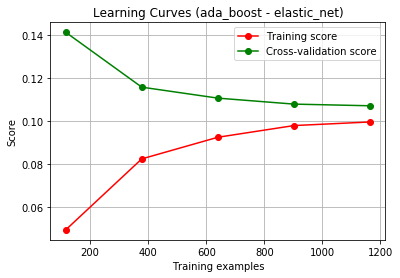

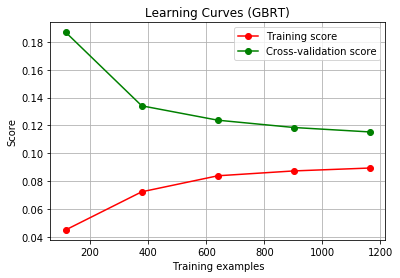

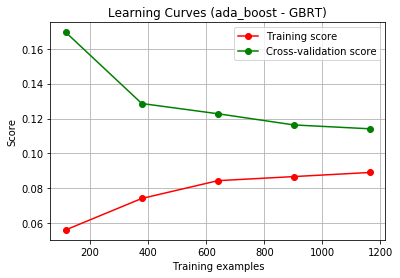

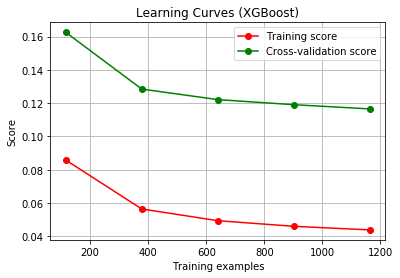

In [85]:
title = "Learning Curves (Ridge)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#plot_learning_curve(ridge, title, X_train, y_train, cv=cv, n_jobs=-1)

title = "Learning Curves (elastic_net)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(elastic_net, title, X_train, y_train, cv=cv, n_jobs=-1)

title = "Learning Curves (RF)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(random_forest, title, X_train, y_train, cv=cv, n_jobs=-1)

title = "Learning Curves (ada_boost - elastic_net)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(ada_boost, title, X_train, y_train, cv=cv, n_jobs=-1)

title = "Learning Curves (GBRT)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(GBRT, title, X_train, y_train, cv=cv, n_jobs=-1)

title = "Learning Curves (ada_boost - GBRT)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(ada_boost_GBRT, title, X_train, y_train, cv=cv, n_jobs=-1)

title = "Learning Curves (XGBoost)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(XGBoost, title, X_train, y_train, cv=cv, n_jobs=1)

title = "Learning Curves (SVM, linear kernel)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#plot_learning_curve(svm_linear, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

## Accuracy

In [71]:
def plot_accuracy(model, title, X_train, y_train, n_jobs=-1):
    y_pred = cross_val_predict(model, X_train, y_train, n_jobs=n_jobs)
    plt.figure()
    plt.title(title)
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.grid()

    plt.plot(y_train, y_pred, 'o', color="r")
    plt.legend(['r^2='+str(r2_score(y_train, y_pred))])
    #plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    x = np.linspace(y_train.min(), y_train.max(), 400)
    plt.plot(x, x, '.', color="g")

    plt.legend(loc="best")
    
    return plt

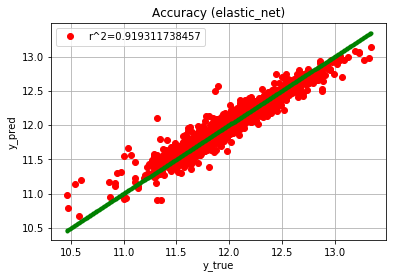

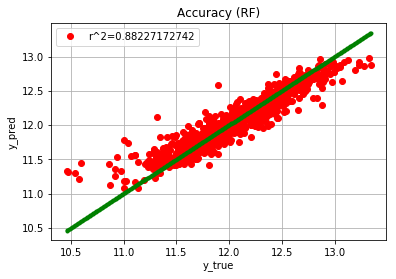

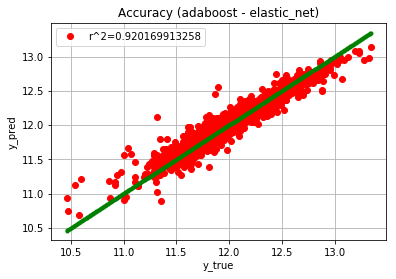

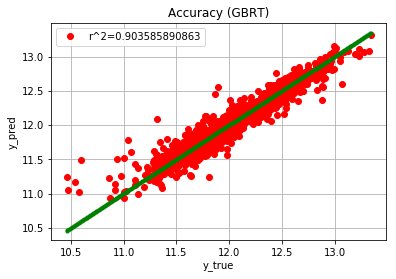

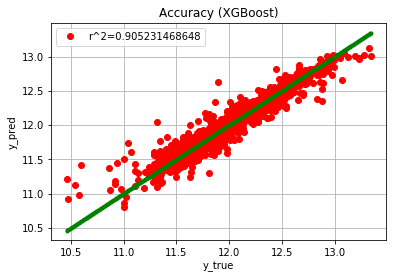

In [72]:
title = "Accuracy (Ridge)"
#plot_accuracy(ridge, title, X_train, y_train, n_jobs=-1)

title = "Accuracy (elastic_net)"
plot_accuracy(elastic_net, title, X_train, y_train, n_jobs=-1)

title = "Accuracy (RF)"
plot_accuracy(random_forest, title, X_train, y_train, n_jobs=-1)

title = "Accuracy (adaboost - elastic_net)"
plot_accuracy(ada_boost, title, X_train, y_train, n_jobs=-1)

title = "Accuracy (GBRT)"
plot_accuracy(GBRT, title, X_train, y_train, n_jobs=1)

title = "Accuracy (XGBoost)"
plot_accuracy(XGBoost, title, X_train, y_train, n_jobs=1)

title = "Accuracy (SVM, linear kernel)"
#plot_accuracy(svm_linear, title, X_train, y_train, n_jobs=-1)

plt.show()

## Stacking

In [79]:
class Stacking(BaseEstimator, RegressorMixin): 
    def __init__(self, model_1, model_2, alpha=1 ,l1_ratio=0.5, max_iter=1000, random_state=42):
        self.model_1 = model_1
        self.model_2 = model_2
        
        self.alpha=alpha
        self.l1_ratio=l1_ratio
        self.max_iter=max_iter
        self.random_state=random_state
        
    def fit(self, X, y):
        print("alpha="+str(self.alpha))
        print("l1_ratio="+str(self.l1_ratio))
        self.blender = ElasticNet(alpha=self.alpha ,l1_ratio=self.l1_ratio, max_iter=self.max_iter, random_state=self.random_state)

        X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
        self.model_1.fit(X_1, y_1)
        self.model_2.fit(X_1, y_1)
        
        y_model_1 = pd.DataFrame(self.model_1.predict(X_2), columns=["y_model_1"])
        y_model_2 = pd.DataFrame(self.model_2.predict(X_2), columns=["y_model_2"])

        X_3 = pd.concat([y_model_1, y_model_2], axis=1)

        self.blender.fit(X_3, y_2)
        
    def predict(self, X, y=None): 
        y_model_1 = pd.DataFrame(self.model_1.predict(X), columns=["y_model_1"])
        y_model_2 = pd.DataFrame(self.model_2.predict(X), columns=["y_model_2"])

        X_blender = pd.concat([y_model_1, y_model_2], axis=1)
        
        y_pred = self.blender.predict(X_blender)
        return y_pred

In [80]:
param_dist = {
    "alpha": uniform(loc=0, scale=1),
    "l1_ratio": uniform(loc=0, scale=1),
    "max_iter": [100000],
    "random_state": [42],
}
model = Stacking(elastic_net, XGBoost)
#optimize_hyperparameters_random(model, param_dist, 10, X_train, y_train.values.ravel())

In [120]:
model = Stacking(elastic_net, XGBoost)
model.set_params(alpha=0.01, l1_ratio=0, max_iter=100000, random_state=42)
model.fit(X_train, y_train)

alpha=0.01
l1_ratio=0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [121]:
submission(model, X_test, "stack")

alpha=0.01
l1_ratio=0
alpha=0.01
l1_ratio=0
alpha=0.01
l1_ratio=0


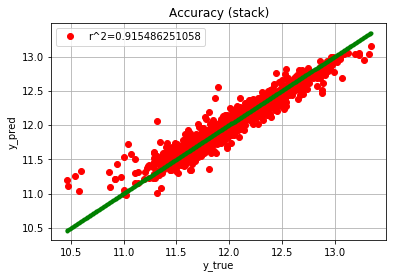

In [122]:
title = "Accuracy (stack)"
plot_accuracy(model, title, X_train, y_train, n_jobs=1)

plt.show()

In [123]:
score(model, X_train, y_train.values.ravel()) #0.112

alpha=0.01
l1_ratio=0
alpha=0.01
l1_ratio=0
alpha=0.01
l1_ratio=0
alpha=0.01
l1_ratio=0
alpha=0.01
l1_ratio=0
Score=0.111944918631


0.121 on leaderboard

## Simple stacking

In [75]:
class Simple_stacking(BaseEstimator, RegressorMixin): 
    def __init__(self, models, coeffs):
        self.models = models
        self.coeffs = coeffs
        
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        
    def predict(self, X, y=None):
        print("coeffs=", self.coeffs)
        y_pred = list()
        for model in self.models:
            y_pred.append(model.predict(X))
        
        prediction = 0
        for i in range(len(self.models)):
            prediction = prediction + self.coeffs[i]*y_pred[i]

        return np.array(prediction)

In [76]:
param_dist = {
    "coeff": uniform(loc=0, scale=1),
}
#model = Simple_stacking(elastic_net, XGBoost)
#optimize_hyperparameters_random(model, param_dist, 10, X_train, y_train.values.ravel(), n_jobs=1)

In [77]:
model = Simple_stacking([elastic_net, XGBoost], coeffs=[0.67,0.33])
model.fit(X_train, y_train)
submission(model, X_test, "simple_stack")

coeffs= [0.67, 0.33]
[ 121939.17784327  160612.78660378  183910.39370324 ...,  163612.29219199
  120281.12436047  219656.33874507]


0.120 on leaderboard

In [78]:
model = Simple_stacking([elastic_net, XGBoost, GBRT], [0.7, 0.2, 0.1])
score(model, X_train, y_train.values.ravel()) #0.108305170529

coeffs= [0.7, 0.2, 0.1]
coeffs= [0.7, 0.2, 0.1]
coeffs= [0.7, 0.2, 0.1]
coeffs= [0.7, 0.2, 0.1]
coeffs= [0.7, 0.2, 0.1]
scores= [ 0.10144216  0.1085963   0.11761674  0.10537712  0.10811235]
Score: mean=0.108228935035 std=0.00533802495847


In [83]:
model = Simple_stacking([ada_boost, ada_boost_GBRT, XGBoost], [0.6, 0.2, 0.2])
score(model, X_train, y_train.values.ravel()) #0.107951775036 0.6, 0.2, 0.2

coeffs= [0.6, 0.2, 0.2]
coeffs= [0.6, 0.2, 0.2]
coeffs= [0.6, 0.2, 0.2]
coeffs= [0.6, 0.2, 0.2]
coeffs= [0.6, 0.2, 0.2]
scores= [ 0.10187368  0.10831434  0.11750033  0.10426996  0.10780057]
Score: mean=0.107951775036 std=0.00532594011181


In [84]:
submission(model, X_test, "simple_stack")

coeffs= [0.6, 0.2, 0.2]
[ 122589.30633025  160012.32337635  183666.68826919 ...,  165071.19872437
  119369.09628205  218674.04778431]


coeffs= [0.6, 0.2, 0.2]
coeffs= [0.6, 0.2, 0.2]
coeffs= [0.6, 0.2, 0.2]


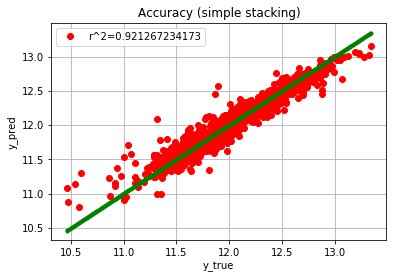

In [73]:
title = "Accuracy (simple stacking)"
plot_accuracy(model, title, X_train, y_train, n_jobs=1)

plt.show()